## Script that finds max energy produced per grid cell. We assume only one HT-ATES system per location, so it picks the layer with highest energy for every grid cell.

Max value in ms, C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz2/msz2__energy_out_P50_basecase_80-45-40.asc: 73138.796875
Total energy in GJ in ms, C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz2/msz2__energy_out_P50_basecase_80-45-40.asc: 13040872.0
Max value in ms, C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz3/msz3__energy_out_P50_basecase_80-45-40.asc: 123204.484375
Total energy in GJ in ms, C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz3/msz3__energy_out_P50_basecase_80-45-40.asc: 22310456.0
Max value in ms, C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz4/msz4__energy_out_P50_basecase_80-45-40.asc: 115132.8359375
Total energy in GJ in ms, C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz4/msz4__energy_out_P50_basecase_80-45-40.asc: 12958969.0
Max value in oo, C:/Users/Johannes/PypsaProject/pypsa-eur-htates

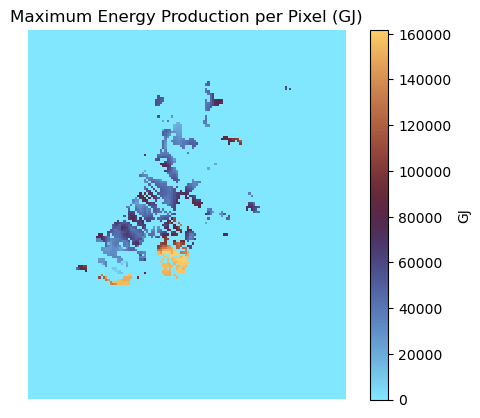

Total area (m²): 4590236724.042859
Total energy (GJ): 70679560.0
 Average MWh/m²: 0.004277
District heating areas available for all requested countries
 9 regions have no ATES potential
      name                                           geometry  ates_potential
0    BE0 0  MULTIPOLYGON (((3936499.001 3000198.74, 393409...    0.000000e+00
1    DE0 0  MULTIPOLYGON (((4079839.074 2906498.883, 40799...    0.000000e+00
2    DK0 0  MULTIPOLYGON (((4297934.658 3548730.871, 42979...    0.000000e+00
3    DK1 0  MULTIPOLYGON (((4440871.917 3510403.407, 44407...    0.000000e+00
4    NL0 0  POLYGON ((4029714.037 3311277.37, 4031280.892 ...    0.000000e+00
5    NL0 1  MULTIPOLYGON (((3956200.615 3191925.257, 39576...    7.303901e+05
6   NL0 10  MULTIPOLYGON (((3884384.922 3156462.858, 38843...    5.852070e+04
7    NL0 2  MULTIPOLYGON (((4048567.817 3200442.335, 40480...    9.310865e+04
8    NL0 3  MULTIPOLYGON (((3971037.568 3268629.553, 39730...    2.987250e+06
9    NL0 4  POLYGON ((4072967.235 

In [8]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmcrameri import cm

#  1. District Heating Coverage Check 
def check_dh_areas_coverage(dh_areas: gpd.GeoDataFrame, countries: list) -> None:
    if countries is None or len(countries) == 0:
        raise ValueError("Countries list is empty or None.")
    if dh_areas.empty:
        raise ValueError("District heating areas dataframe is empty.")
    if "country" in dh_areas.columns:
        dh_countries = set(dh_areas["country"].unique())
    else:
        raise KeyError("Cannot find 'country' column in district heating areas dataframe.")
    
    missing_countries = set(countries) - dh_countries
    if missing_countries:
        print(f" No district heating areas found for the following countries: {', '.join(missing_countries)}")
    else:
        print("District heating areas available for all requested countries")

#  2. MWh/m² Calculation Function 
def calculate_total_avg_mwh_per_m2(HTATES_potential, aquifer_energy):
    from shapely.ops import unary_union

    all_max_energy_layers = []
    all_geoms = []

    for key in HTATES_potential:
        potential = HTATES_potential[key] # suitable HT-ATES areas
        energy = aquifer_energy[key] # energy produced in GJ
        if potential.empty:
            continue

        geoms = potential.geometry.values
        all_geoms.extend(geoms)

        for raster_path in energy:
            with rasterio.open(raster_path) as src:
                out_image, _ = mask(src, geoms, crop=False, nodata=np.nan) # with geoms include only suitable HT-ATES areas
                data = out_image[0]
                data = np.where(np.isnan(data), 0, data)
                all_max_energy_layers.append(data) # Store energy data of each aquifer layer
            # To check the range possible for energy production:
            print(f"Max value in {key}, {raster_path}: {data.max()}")
            print(f"Total energy in GJ in {key}, {raster_path}: {data.sum()}")

    if not all_max_energy_layers:
        return 0.0

    # Take the maximum energy value for each pixel across all aquifer layers
    max_energy = np.max(np.stack(all_max_energy_layers), axis=0)
    total_energy = max_energy.sum()  # GJ

    # Plot the maximum energy raster
    plt.imshow(max_energy, cmap=cm.managua.reversed(), interpolation='nearest')
    plt.title("Maximum Energy Production per Pixel (GJ)")
    plt.colorbar(label="GJ")
    plt.axis('off')
    plt.show()

    # Total area (union of all HT-ATES geometries):
    # Merge the geometries of all potential maps, dissolving overlapping shapes into one
    # to avoid counting the same area multiple times when we find the total area
    union_geom = unary_union(all_geoms) 
    area_gdf = gpd.GeoDataFrame(geometry=[union_geom], crs=HTATES_potential[list(HTATES_potential.keys())[0]].crs)
    total_area = area_gdf.geometry.area.sum()  # m²

    total_mwh_per_m2 = (total_energy * (1000/3600)) / total_area if total_area > 0 else 0.0
    print(f"Total area (m²): {total_area}")
    print(f"Total energy (GJ): {total_energy}")
    return total_mwh_per_m2, area_gdf

#  3. ATES Potential Calculation Per Cluster 
def calculate_ates_potential_per_cluster(
    regions_onshore: gpd.GeoDataFrame,
    dh_areas: gpd.GeoDataFrame,
    suitable_aquifers: gpd.GeoDataFrame,
    dh_area_buffer: float,
    mwh_per_m2: float,
):
    ret_val = regions_onshore.copy()
    if "name" not in ret_val.columns:
        raise KeyError("Column 'name' not found in regions.")
    
    ret_val.index = ret_val["name"]
    ret_val.drop(columns=["name"], inplace=True)

    # Filter aquifers to only those in regions
    suitable_in_regions = gpd.overlay(suitable_aquifers, regions_onshore, how="intersection")

    # Buffer district heating areas
    dh_areas_buffered = dh_areas.copy()
    dh_areas_buffered["geometry"] = dh_areas_buffered.geometry.buffer(dh_area_buffer)

    try:
        aquifers_in_dh_areas = (
            gpd.overlay(dh_areas_buffered, suitable_in_regions, how="intersection")
            .groupby("name")["geometry"]
            .apply(lambda x: x.area.sum())
        )

        missing_regions = set(ret_val.index) - set(aquifers_in_dh_areas.index)
        if missing_regions:
            print(f" {len(missing_regions)} regions have no ATES potential")

        ret_val["ates_potential"] = 0.0
        ret_val.loc[aquifers_in_dh_areas.index, "ates_potential"] = aquifers_in_dh_areas * mwh_per_m2

    except Exception as e:
        print(f" Error during overlay: {e}")
        ret_val["ates_potential"] = 0.0

    return ret_val.reset_index()

#  4. Run

# 1. Load input files
regions_onshore = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/resources/regions_onshore_base_s_16.geojson").to_crs(3035)
htates_ms = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES-potential/-Total_Formation_ms.shp")
htates_oo = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES-potential/-Total_Formation_oo.shp")
dh_areas = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/dh_areas.gpkg").to_crs(3035)

# 2. Filter HT-ATES data
htates_filtered = {
    "ms": htates_ms[htates_ms["DN"] == 3000],
    "oo": htates_oo[htates_oo["DN"] == 3000],
}

# 3. Compute MWh/m²
raster_paths = {
    "ms": [
        "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz2/msz2__energy_out_P50_basecase_80-45-40.asc",
        "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz3/msz3__energy_out_P50_basecase_80-45-40.asc",
        "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz4/msz4__energy_out_P50_basecase_80-45-40.asc",
    ],
    "oo": ["C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_ooz2/ooz2__energy_out_P50_basecase_80-45-40.asc"],
}

mwh_per_m2, suitable_aquifers = calculate_total_avg_mwh_per_m2(htates_filtered, raster_paths)
print(f" Average MWh/m²: {mwh_per_m2:.6f}")

# 4. Check district heating coverage
countries = ["NL"]  # Example
check_dh_areas_coverage(dh_areas, countries)

# 5. Extract suitable aquifers # CHANGE THIS TO A UNARY UNION THING OF MS AND OO TOGETHER
#suitable_aquifers = htates_nl_total[htates_nl_total["DN"]==3000] # This results in slightly higher MWh values per cluster
suitable_aquifers = suitable_aquifers.set_crs(epsg=28992).to_crs(epsg=3035)

# 6. Compute potentials
dh_buffer = 1000
results = calculate_ates_potential_per_cluster(
    regions_onshore=regions_onshore,
    dh_areas=dh_areas,
    suitable_aquifers=suitable_aquifers,
    dh_area_buffer=dh_buffer,
    mwh_per_m2=mwh_per_m2,
)

print(results)

## Maximum energy production before and after location filtering

In [5]:
import geopandas as gpd
regions_onshore = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/resources/regions_onshore_base_s_9.geojson")
htates_nl_total = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES-potential/-Total_Netherlands.shp")
htates_ms = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES-potential/-Total_Formation_ms.shp")
htates_oo = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES-potential/-Total_Formation_oo.shp")
htates_nlffs = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES-potential/-Total_NLFFS.shp")
dh_areas = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/dh_areas.gpkg")

print(htates_nl_total.crs)
print(dh_areas.crs)
print(htates_ms.crs)

None
EPSG:3035
None


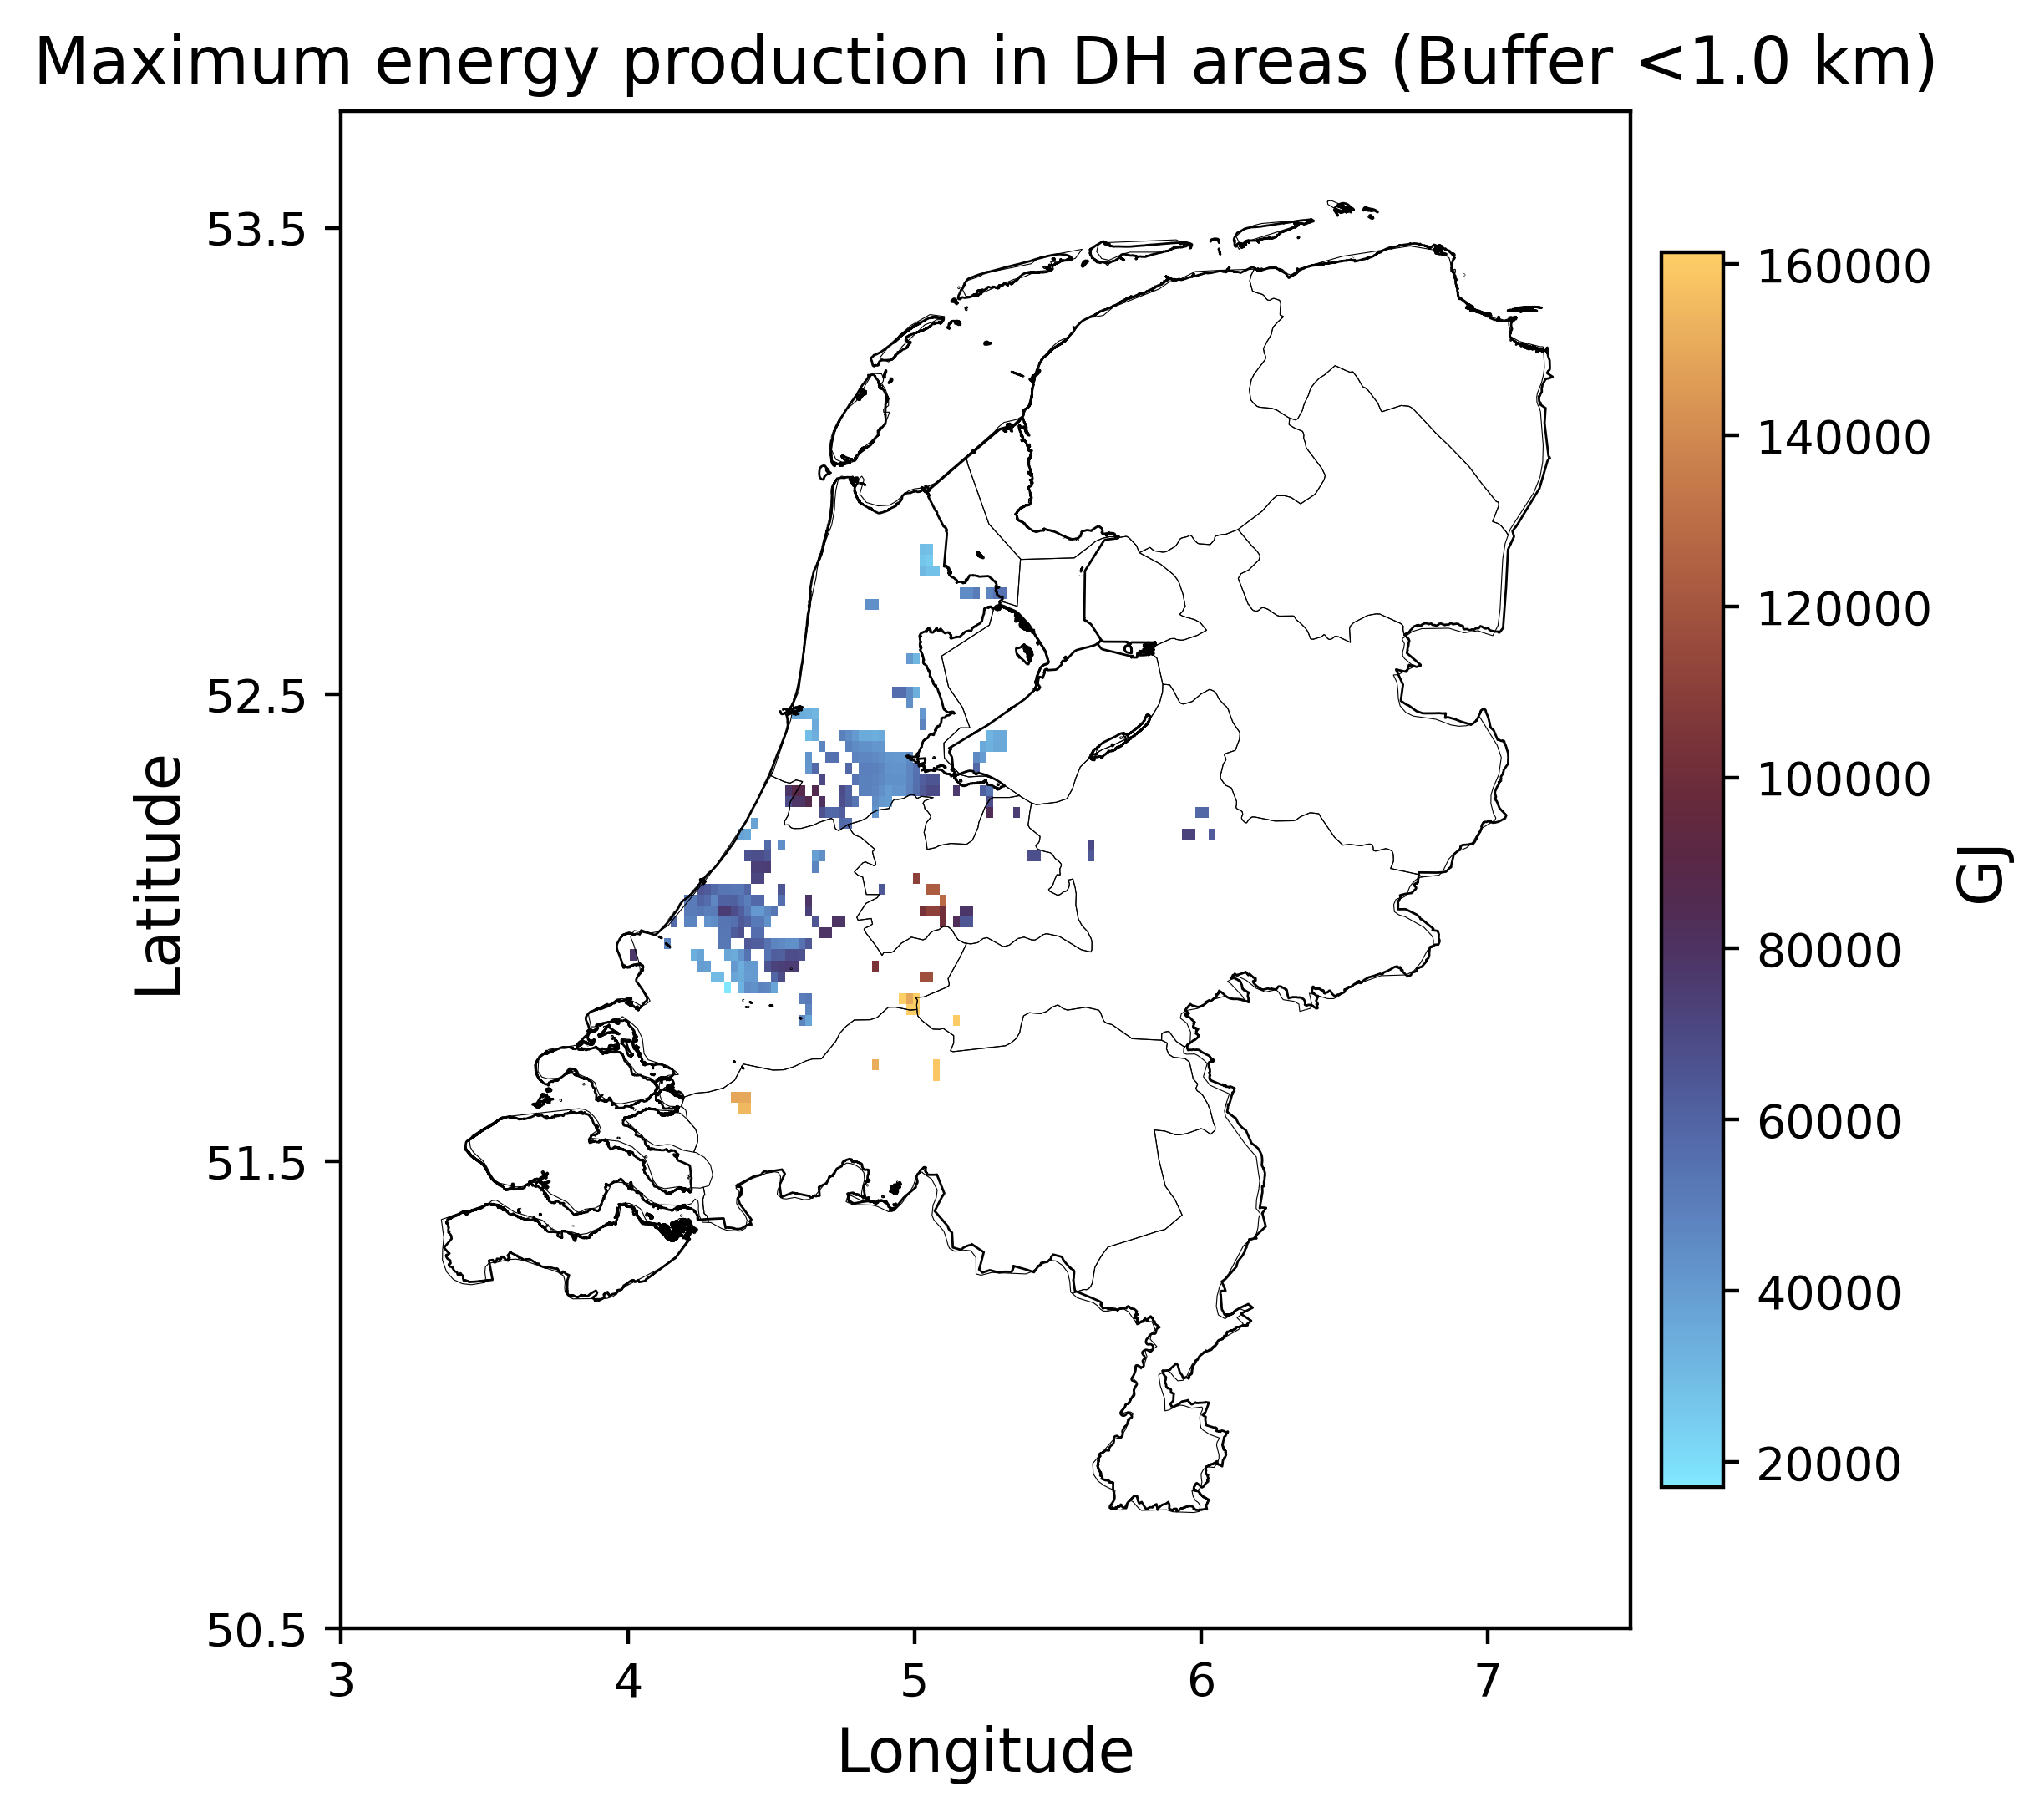

In [12]:
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.crs import CRS

def calculate_total_avg_mwh_per_m2(HTATES_potential, aquifer_energy):
    from shapely.ops import unary_union

    all_max_energy_layers = []
    all_geoms = []

    for key in HTATES_potential:
        potential = HTATES_potential[key] # suitable HT-ATES areas
        energy = aquifer_energy[key] # energy produced in GJ
        if potential.empty:
            continue

        geoms = potential.geometry.values
        all_geoms.extend(geoms)

        for raster_path in energy:
            with rasterio.open(raster_path) as src:
                out_image, _ = mask(src, geoms, crop=False, nodata=np.nan) # with geoms include only suitable HT-ATES areas
                data = out_image[0]
                data = np.where(np.isnan(data), 0, data)
                all_max_energy_layers.append(data) # Store energy data of each aquifer layer

    if not all_max_energy_layers:
        return 0.0

    # Take the maximum energy value for each pixel across all aquifer layers
    max_energy = np.max(np.stack(all_max_energy_layers), axis=0)
    total_energy = max_energy.sum()  # GJ

    admin = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/Notebooks/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
    provinces = admin[admin['admin'] == "Netherlands"]
    provinces = provinces.to_crs(epsg=4326)
    netherlands = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/Notebooks/NL_borders25.geojson")
    netherlands = netherlands.to_crs(epsg=4326)

    example_raster = raster_paths[list(raster_paths.keys())[0]][0]
    with rasterio.open(example_raster) as src:
        src_crs = CRS.from_epsg(28992)
        src_transform = src.transform
        src_bounds = src.bounds
        height, width = max_energy.shape
        dst_crs = CRS.from_epsg(4326)

        dst_transform, dst_width, dst_height = calculate_default_transform(
            src_crs, dst_crs, width, height, *src.bounds
        )

        dst_array = np.empty((dst_height, dst_width), dtype=np.float32)

        reproject(
            source=max_energy,
            destination=dst_array,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

    #  Plotting 
    fig, ax = plt.subplots(figsize=(6, 8))
    # Plot Netherlands border first
    netherlands.boundary.plot(ax=ax, color='black', linewidth=0.5)
    provinces.boundary.plot(ax=ax, color='black', linewidth=0.2)
    # Plot the maximum energy raster
    extent = [
        dst_transform[2],
        dst_transform[2] + dst_transform[0] * dst_width,
        dst_transform[5] + dst_transform[4] * dst_height,
        dst_transform[5],
    ]
    masked_array = np.ma.masked_where(dst_array == 0, dst_array)
    # Plot white background first
    ax.imshow(np.ones_like(dst_array), extent=extent, cmap="gray", vmin=0, vmax=1)
    # Plot energy data on top
    im = ax.imshow(masked_array, extent=extent, cmap=cm.managua.reversed(), interpolation='nearest')

    plt.title("Maximum energy production", fontsize=14)
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.02)
    cbar.set_label(label="GJ", size=13)
    cbar.ax.tick_params(labelsize=10)
    #ax.set_aspect('auto')
    ax.set_ylim(50.5,53.75)
    ax.set_xlim(3,7.5)
    ax.set_yticks(np.arange(50.5,54,1))
    ax.set_xticks(np.arange(3, 7.5,1))
    ax.set_aspect(1.0 / np.cos(np.deg2rad(np.mean([50.5, 53.75]))))
    ax.set_xlabel("Longitude", fontsize=13)
    ax.set_ylabel("Latitude", fontsize=13)
    plt.show()

    # Total area (union of all HT-ATES geometries)
    # Merge the geometries of all potential maps, dissolving overlapping shapes into one
    # to avoid counting the same area multiple times when we find the total area
    union_geom = unary_union(all_geoms) 
    area_gdf = gpd.GeoDataFrame(geometry=[union_geom], crs=HTATES_potential[list(HTATES_potential.keys())[0]].crs)
    total_area = area_gdf.geometry.area.sum()  # m²

    total_mwh_per_m2 = (total_energy * (1000/3600)) / total_area if total_area > 0 else 0.0
    print(f"Total area (m²): {total_area}")
    print(f"Total energy (GJ): {total_energy}")
    return total_mwh_per_m2, area_gdf


dh_buffer = 1000  # meters
dh_areas = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/dh_areas.gpkg")
#  1. Buffer DH areas in EPSG:28992 (meters) 
dh_areas_proj = dh_areas.to_crs(epsg=28992)
dh_areas_buffered = dh_areas_proj.buffer(dh_buffer)
dh_areas_buffered = gpd.GeoDataFrame(geometry=dh_areas_buffered, crs=28992)

#  2. Project suitable aquifers to same CRS and intersect 
suitable_aquifers_proj = suitable_aquifers.to_crs(epsg=28992)
intersection_geom = gpd.overlay(suitable_aquifers_proj, dh_areas_buffered, how="intersection")

#  3. Raster masking (geometry must match raster CRS: 28992) 
all_max_energy_layers = []
all_geoms = [geom for geom in intersection_geom.geometry.values]

for key in htates_filtered:
    for raster_path in raster_paths[key]:
        with rasterio.open(raster_path) as src:
            out_image, _ = mask(src, all_geoms, crop=False, nodata=np.nan)
            data = out_image[0]
            data = np.where(np.isnan(data), 0, data)
            all_max_energy_layers.append(data)

#  4. Aggregate max energy 
max_energy = np.max(np.stack(all_max_energy_layers), axis=0)
total_energy = max_energy.sum()  # GJ

#  5. Reproject raster to EPSG:4326 for plotting 
example_raster = raster_paths["ms"][0]
with rasterio.open(example_raster) as src:
    src_crs = CRS.from_epsg(28992)
    src_transform = src.transform
    height, width = max_energy.shape
    dst_crs = CRS.from_epsg(4326)

    dst_transform, dst_width, dst_height = calculate_default_transform(
        src_crs, dst_crs, width, height, *src.bounds
    )
    dst_array = np.empty((dst_height, dst_width), dtype=np.float32)

    reproject(
        source=max_energy,
        destination=dst_array,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

#  6. Plot 
admin = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/Notebooks/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
provinces = admin[admin['admin'] == "Netherlands"].to_crs(epsg=4326)
netherlands = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/Notebooks/NL_borders25.geojson").to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(6, 8), dpi=400)
netherlands.boundary.plot(ax=ax, color='black', linewidth=0.5)
provinces.boundary.plot(ax=ax, color='black', linewidth=0.2)

extent = [
    dst_transform[2],
    dst_transform[2] + dst_transform[0] * dst_width,
    dst_transform[5] + dst_transform[4] * dst_height,
    dst_transform[5],
]
masked_array = np.ma.masked_where(dst_array == 0, dst_array)

# White background
ax.imshow(np.ones_like(dst_array), extent=extent, cmap="gray", vmin=0, vmax=1)

# Plot max energy
im = ax.imshow(masked_array, extent=extent, cmap=cm.managua.reversed(), interpolation='nearest')

plt.title(f"Maximum energy production in DH areas (Buffer <{dh_buffer/1000:.1f} km)", fontsize=14)
cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.02)
cbar.set_label(label="GJ", size=13)
cbar.ax.tick_params(labelsize=10)

ax.set_ylim(50.5, 53.75)
ax.set_xlim(3, 7.5)
ax.set_yticks(np.arange(50.5, 54, 1))
ax.set_xticks(np.arange(3, 8, 1))
ax.set_aspect(1.0 / np.cos(np.deg2rad(np.mean([50.5, 53.75]))))
ax.set_xlabel("Longitude", fontsize=13)
ax.set_ylabel("Latitude", fontsize=13)
plt.show()


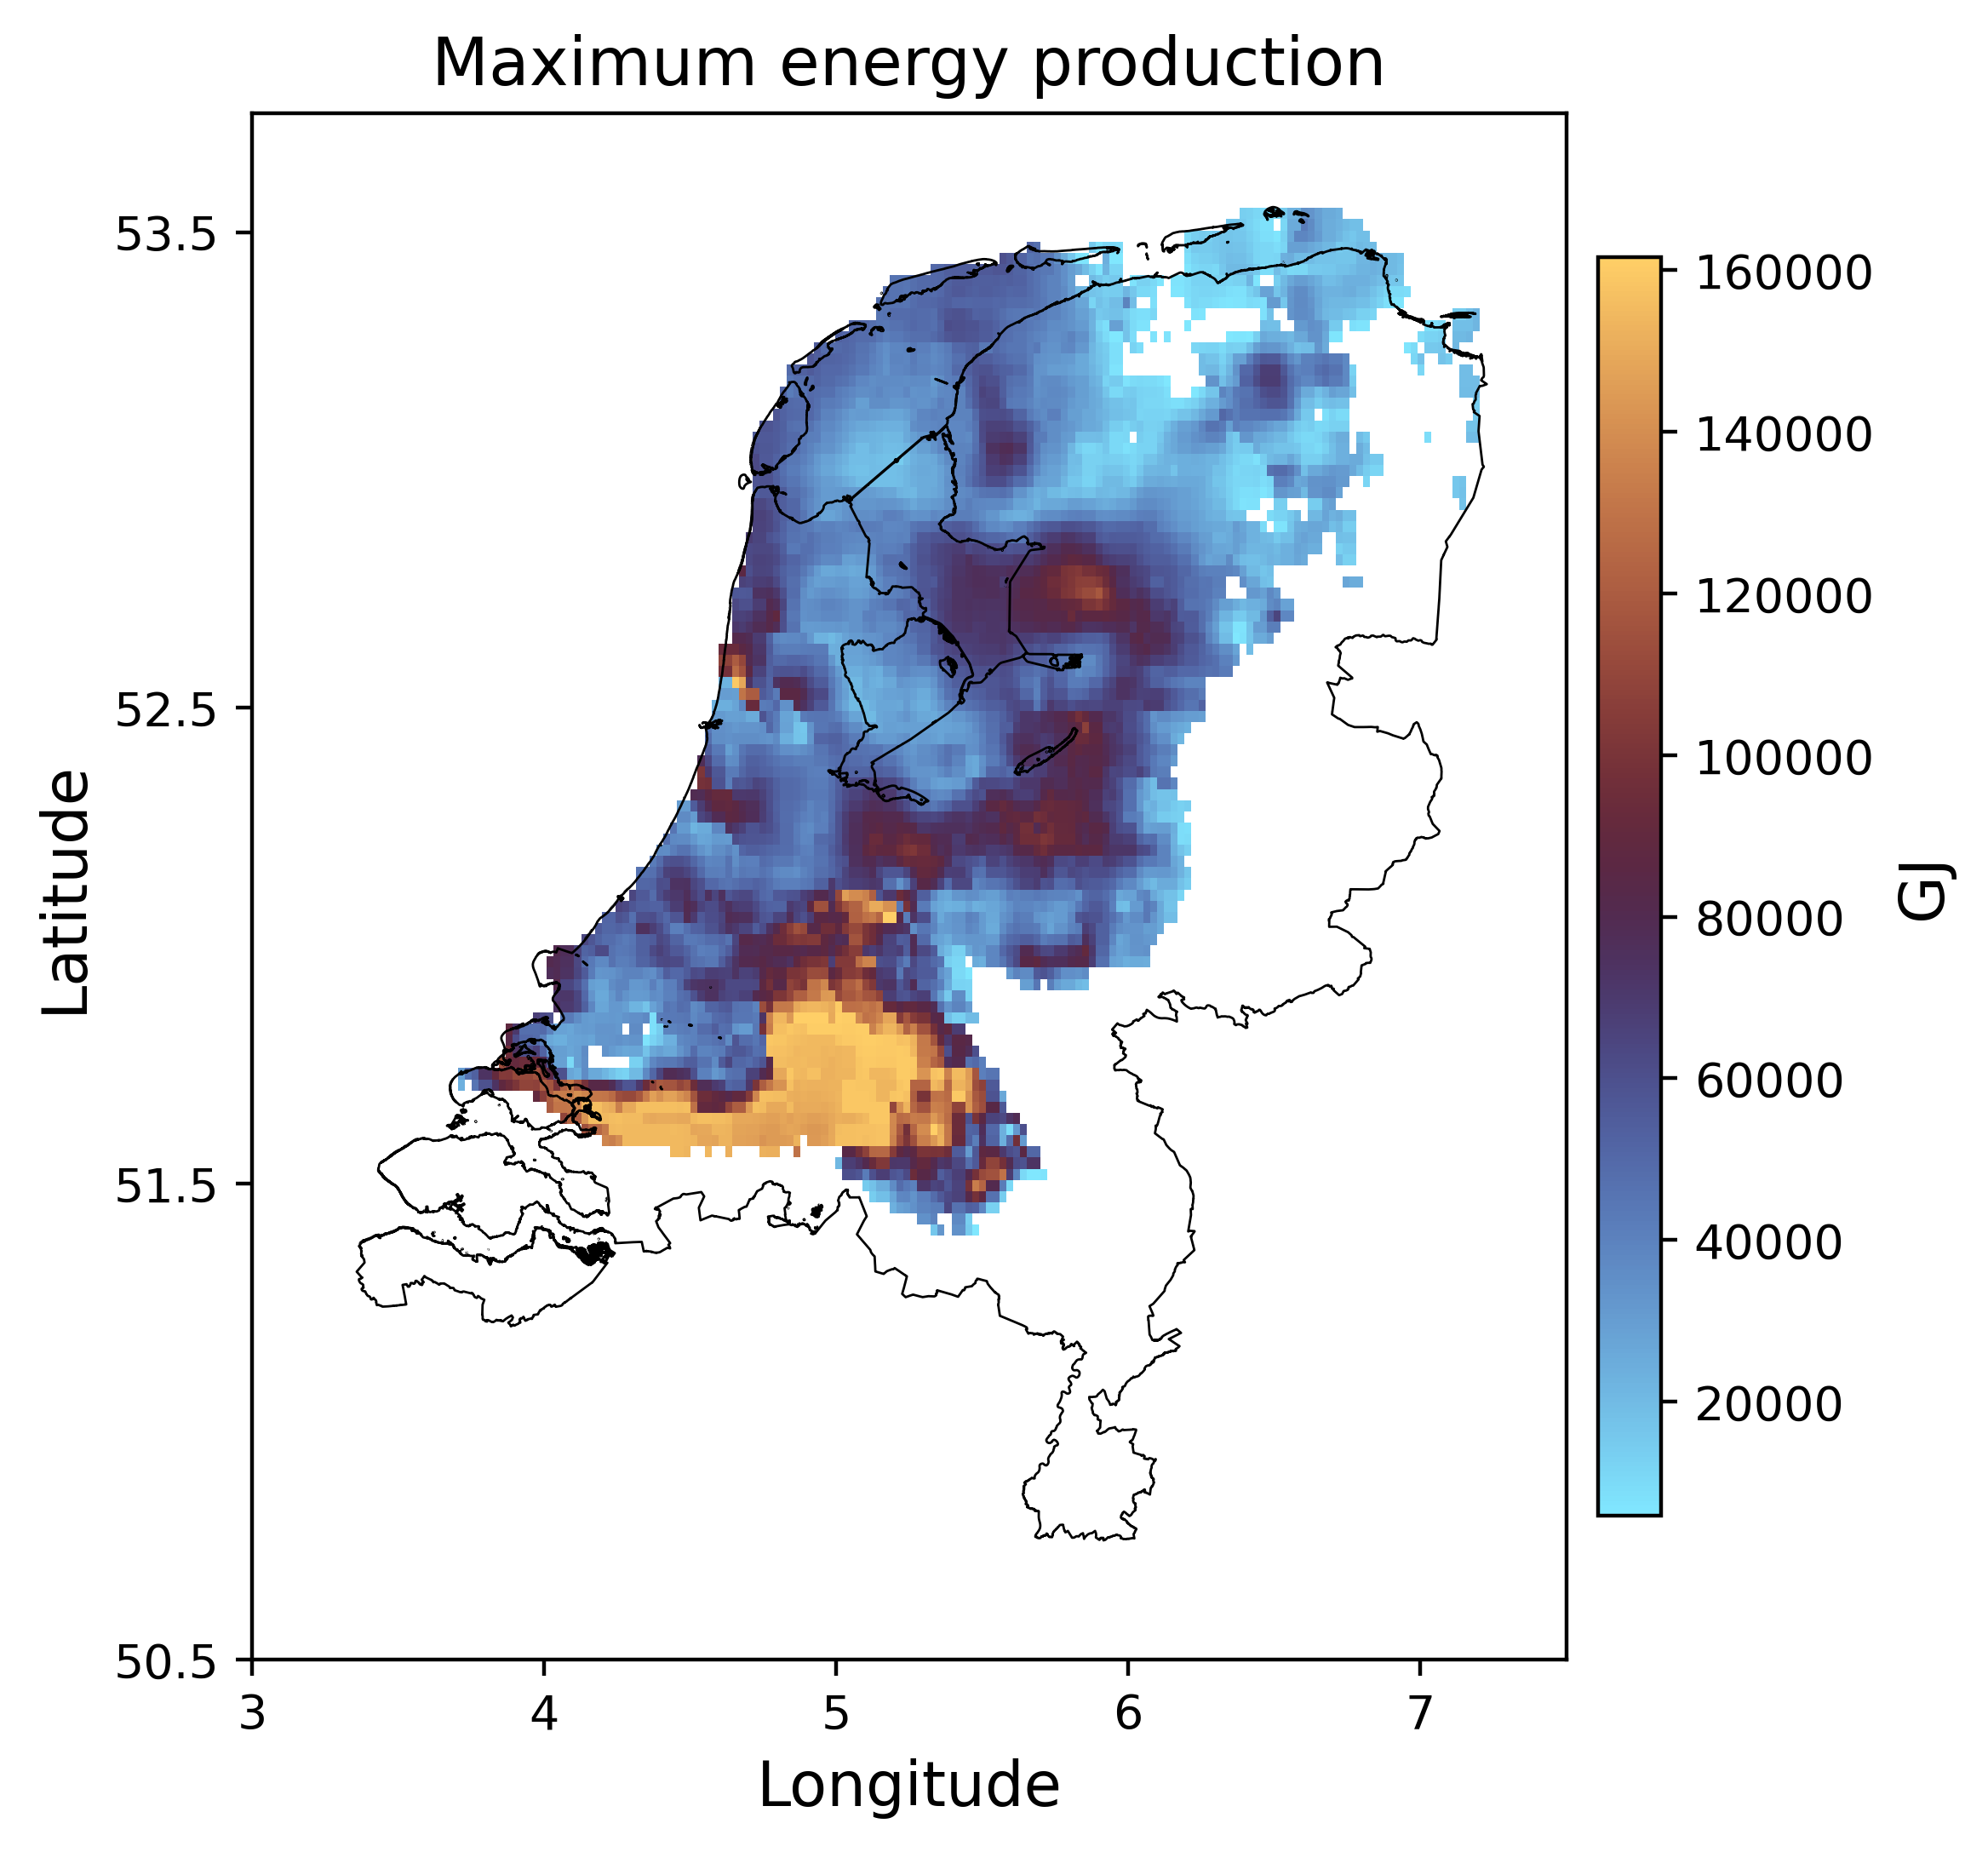

Total unfiltered energy (GJ): 364956704.0


In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.crs import CRS
def plot_max_energy_unfiltered(raster_paths):
    all_max_energy_layers = []

    for key in raster_paths:
        for raster_path in raster_paths[key]:
            with rasterio.open(raster_path) as src:
                data = src.read(1)
                data = np.where(data == src.nodata, 0, data)
                all_max_energy_layers.append(data)

    if not all_max_energy_layers:
        print("No raster data found.")
        return

    # Calculate max across all layers
    max_energy = np.max(np.stack(all_max_energy_layers), axis=0)
    total_energy = max_energy.sum()  # Optional if you want to report it

    # Reproject raster to EPSG:4326
    example_raster = raster_paths[list(raster_paths.keys())[0]][0]
    with rasterio.open(example_raster) as src:
        src_crs = src.crs or CRS.from_epsg(28992)  # Fix here
        src_transform = src.transform
        height, width = max_energy.shape
        dst_crs = CRS.from_epsg(4326)

        dst_transform, dst_width, dst_height = calculate_default_transform(
            src_crs, dst_crs, width, height, *src.bounds
        )

        dst_array = np.empty((dst_height, dst_width), dtype=np.float32)

        reproject(
            source=max_energy,
            destination=dst_array,
            src_transform=src_transform,
            src_crs=src_crs,
            dst_transform=dst_transform,
            dst_crs=dst_crs,
            resampling=Resampling.nearest
        )

    #  Plotting 
    netherlands = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/Notebooks/NL_borders25.geojson").to_crs(epsg=4326)
    provinces = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/Notebooks/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
    provinces = provinces[provinces['admin'] == "Netherlands"].to_crs(epsg=4326)

    fig, ax = plt.subplots(figsize=(6, 8), dpi=400)
    netherlands.boundary.plot(ax=ax, color='black', linewidth=0.5)
    #provinces.boundary.plot(ax=ax, color='black', linewidth=0.2)

    extent = [
        dst_transform[2],
        dst_transform[2] + dst_transform[0] * dst_width,
        dst_transform[5] + dst_transform[4] * dst_height,
        dst_transform[5],
    ]

    masked_array = np.ma.masked_where(dst_array == 0, dst_array)
    ax.imshow(np.ones_like(dst_array), extent=extent, cmap="gray", vmin=0, vmax=1)
    im = ax.imshow(masked_array, extent=extent, cmap=cm.managua.reversed(), interpolation='nearest')

    plt.title("Maximum energy production", fontsize=14)
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, pad=0.02)
    cbar.set_label(label="GJ", size=13)
    cbar.ax.tick_params(labelsize=10)

    ax.set_ylim(50.5, 53.75)
    ax.set_xlim(3, 7.5)
    ax.set_yticks(np.arange(50.5, 54, 1))
    ax.set_xticks(np.arange(3, 7.5, 1))
    ax.set_aspect(1.0 / np.cos(np.deg2rad(np.mean([50.5, 53.75]))))
    ax.set_xlabel("Longitude", fontsize=13)
    ax.set_ylabel("Latitude", fontsize=13)
    plt.show()

    print(f"Total unfiltered energy (GJ): {total_energy}")


# 1. Load input files
htates_ms = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES-potential/-Total_Formation_ms.shp")#.set_crs(epsg=28992).to_crs(epsg=4326)
htates_oo = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES-potential/-Total_Formation_oo.shp")#.set_crs(epsg=28992).to_crs(epsg=4326)

# 2. Filter HT-ATES data
htates_filtered = {
    "ms": htates_ms[htates_ms["DN"] == 3000],
    "oo": htates_oo[htates_oo["DN"] == 3000],
}

# 3. Compute MWh/m²
raster_paths = {
    "ms": [
        "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz2/msz2__energy_out_P50_basecase_80-45-40.asc",
        "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz3/msz3__energy_out_P50_basecase_80-45-40.asc",
        "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz4/msz4__energy_out_P50_basecase_80-45-40.asc",
    ],
    "oo": ["C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_ooz2/ooz2__energy_out_P50_basecase_80-45-40.asc"],
}

plot_max_energy_unfiltered(raster_paths)



## The HT-ATES potential and energy production per formation

C:\Users\Johannes\AppData\Local\Temp\ipykernel_30348\346224445.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


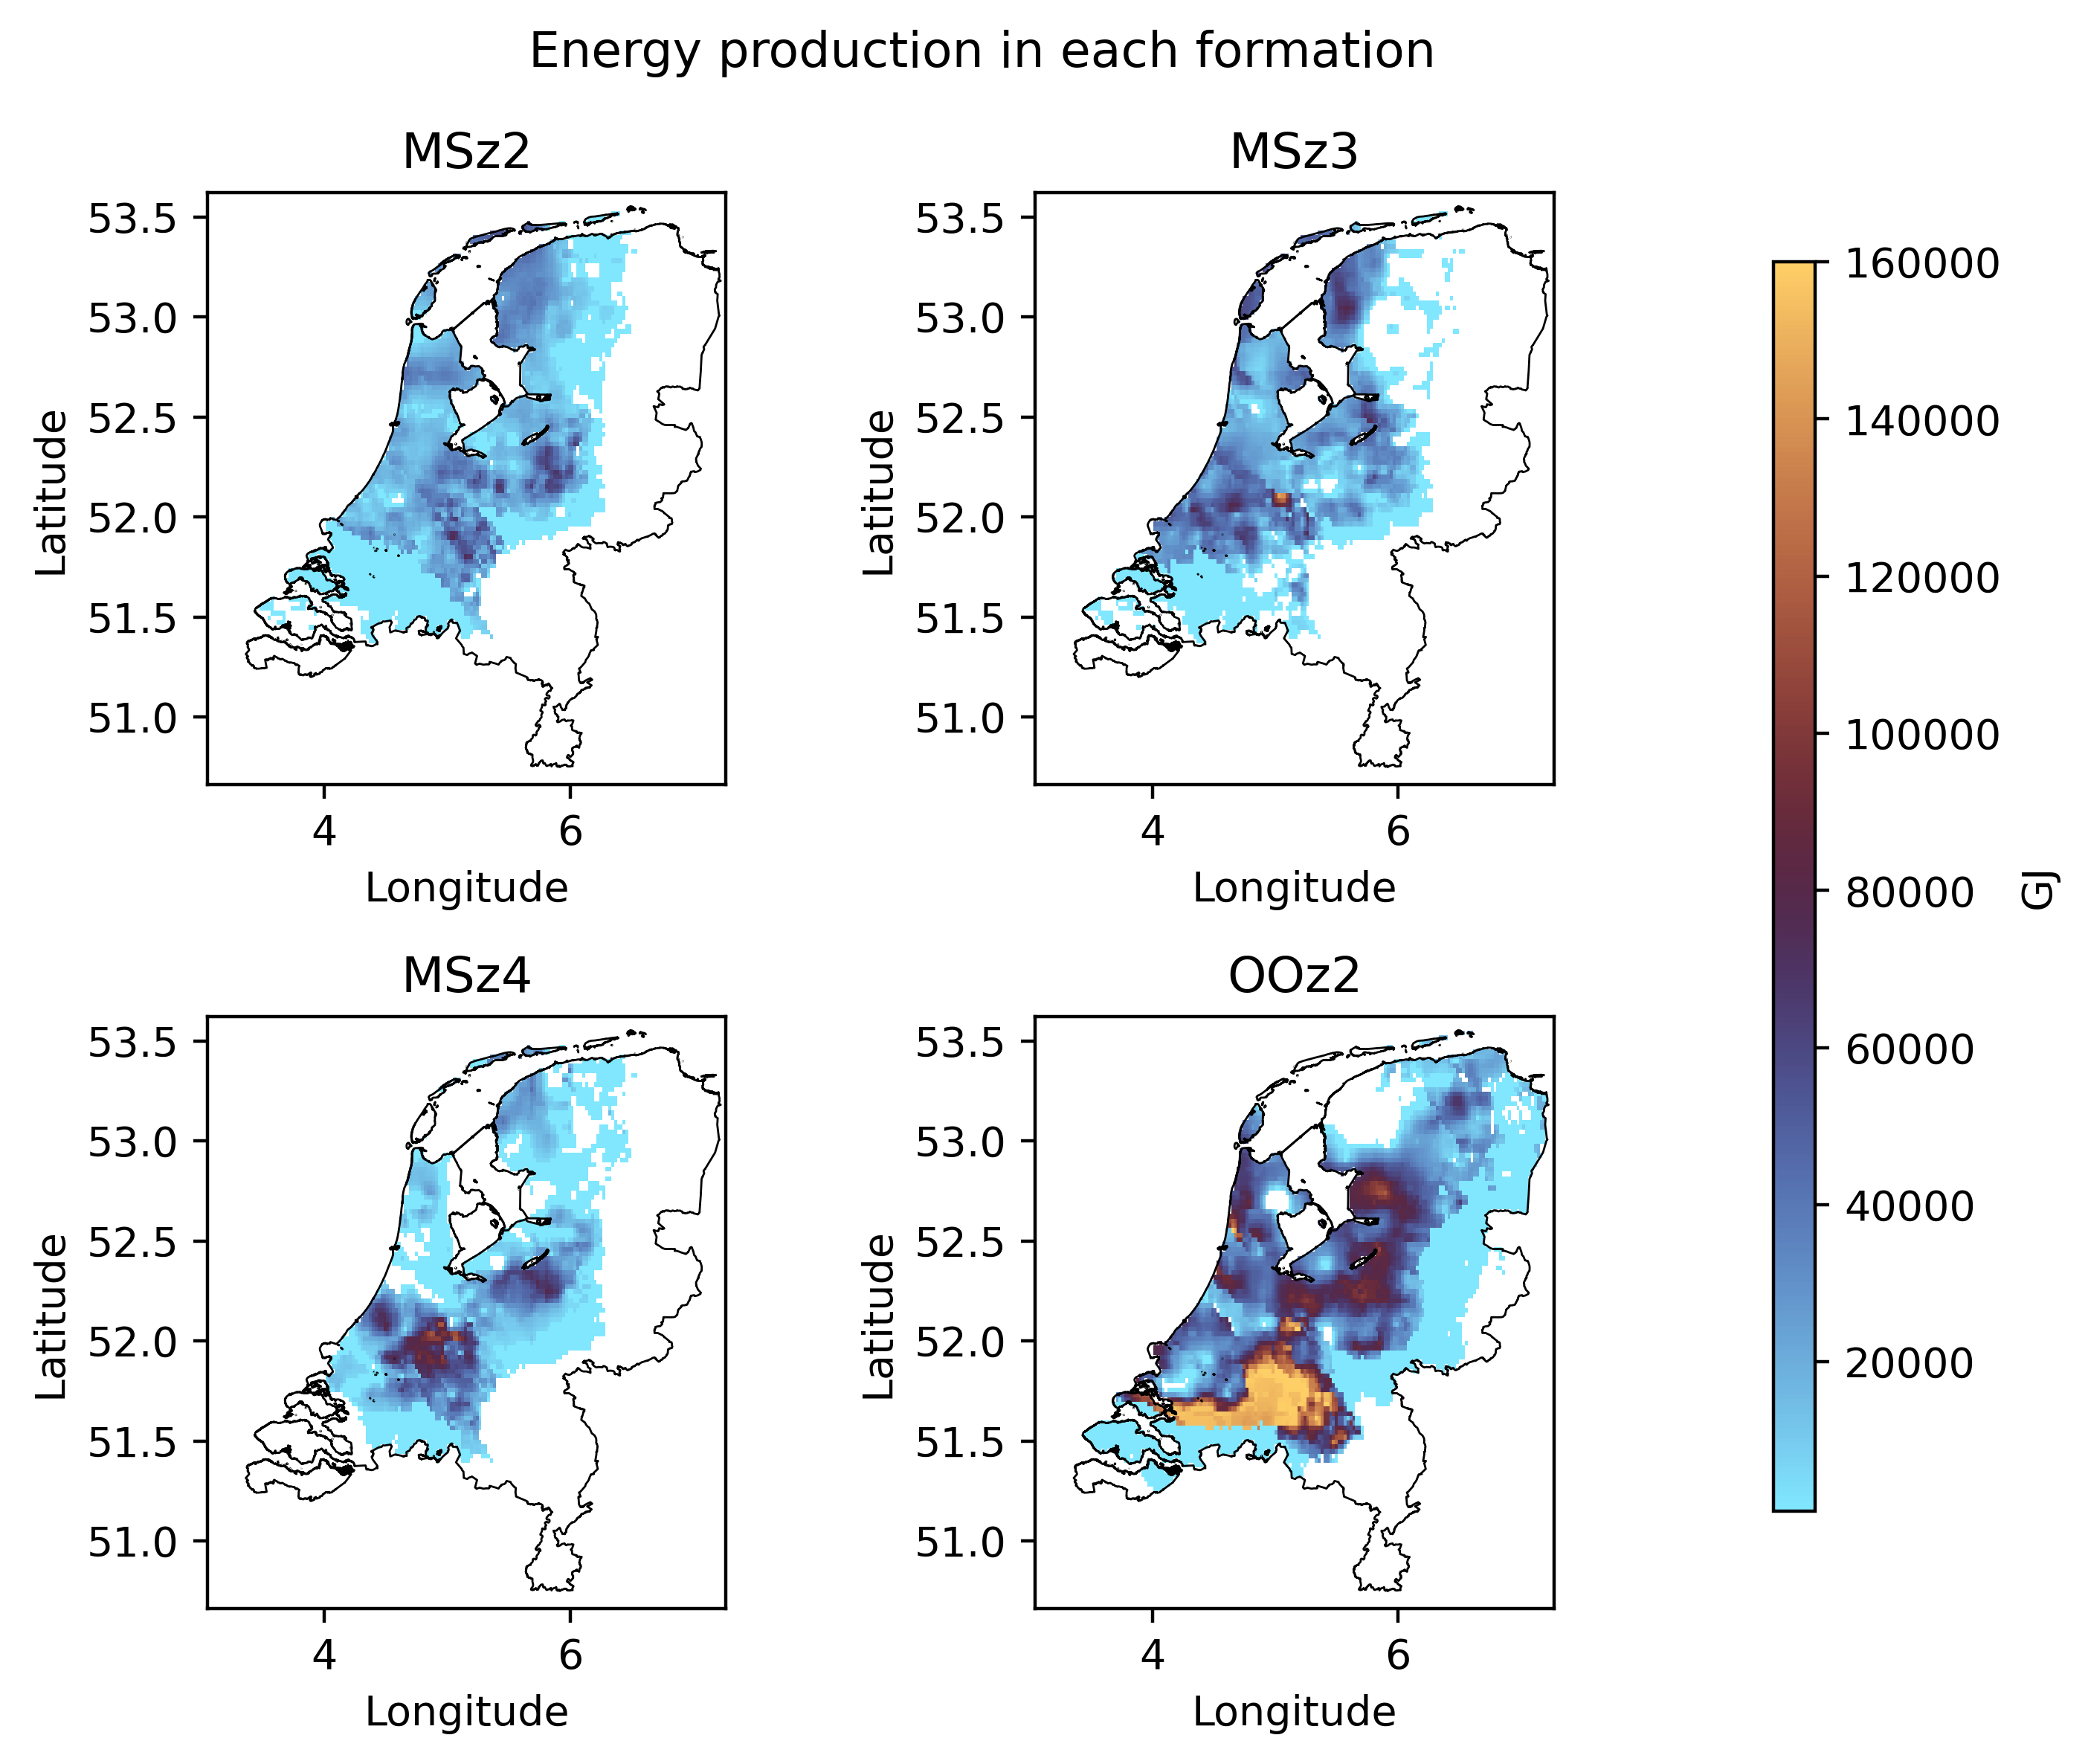

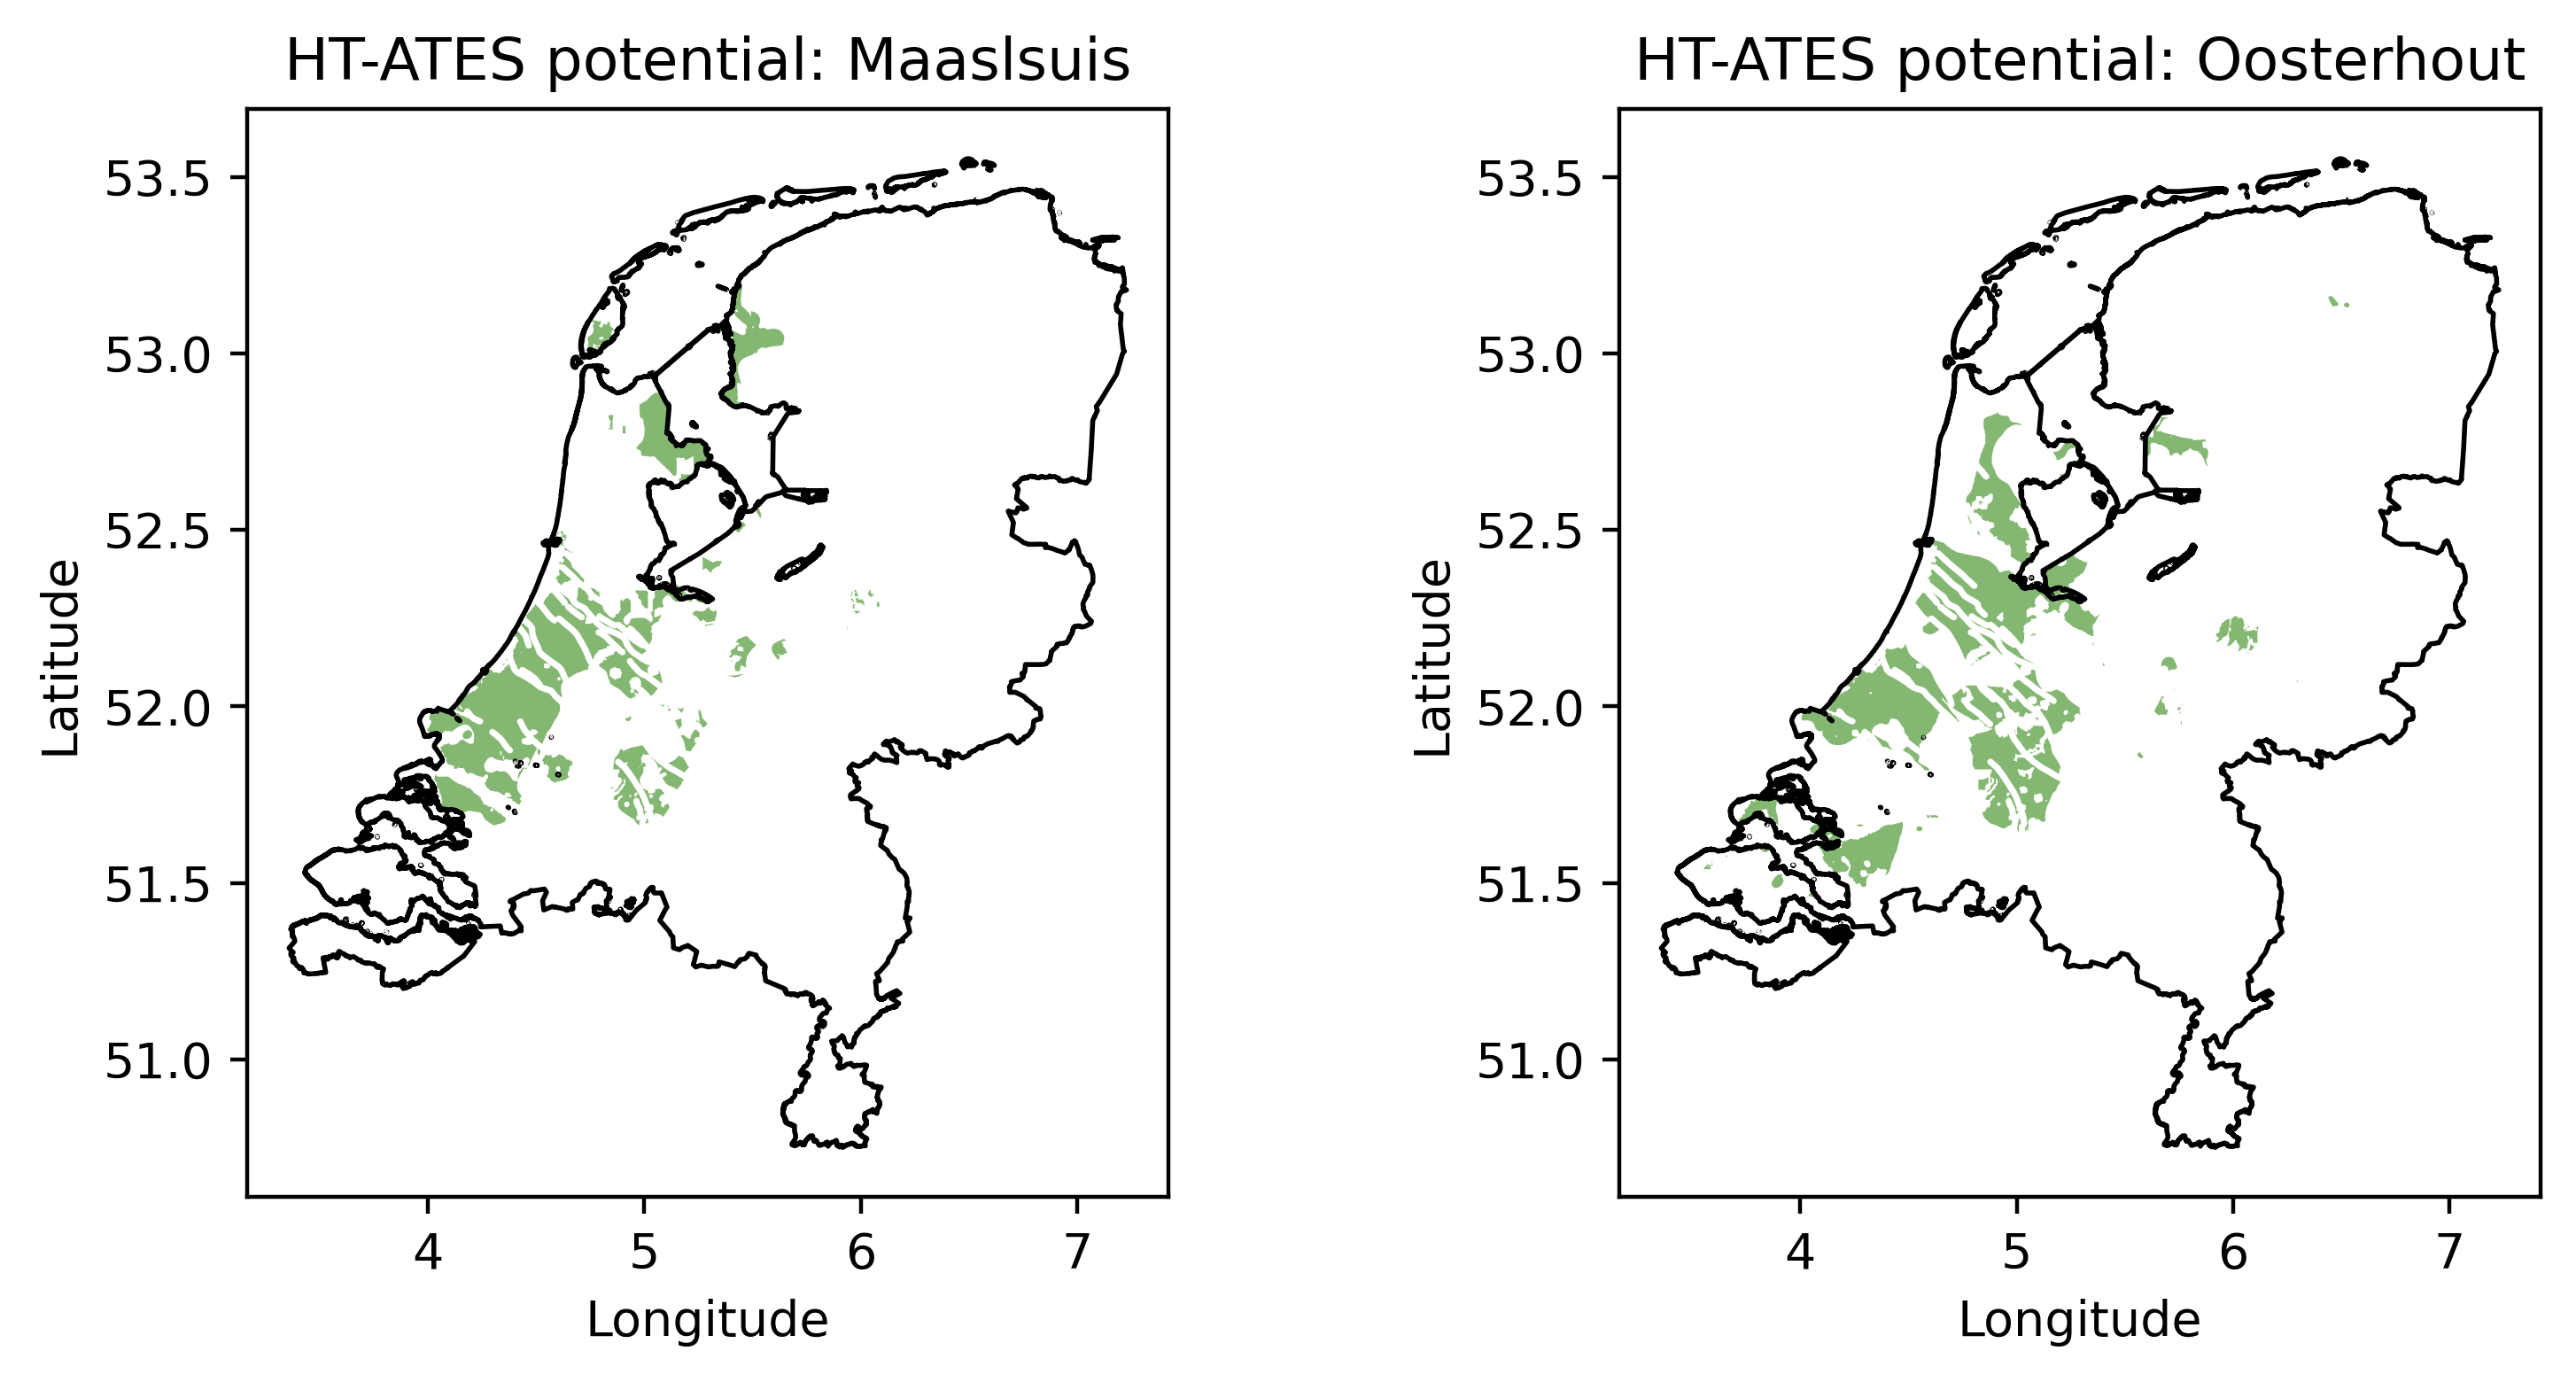

In [11]:
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from rasterio.io import MemoryFile

netherlands = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/Notebooks/NL_borders25.geojson").to_crs(epsg=4326)

layer_names = ['MSz2', 'MSz3', 'MSz4', 'OOz2']
paths = [
    "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz2/msz2__energy_out_P50_basecase_80-45-40.asc",
    "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz3/msz3__energy_out_P50_basecase_80-45-40.asc",
    "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz4/msz4__energy_out_P50_basecase_80-45-40.asc",
    "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_ooz2/ooz2__energy_out_P50_basecase_80-45-40.asc"
]

fig, axs = plt.subplots(2, 2, figsize=(7, 6), dpi=400)
axs = axs.flatten()

im = None  # placeholder for the image handle

netherlands_wgs84 = netherlands.to_crs("EPSG:4326")

for ax, path, name in zip(axs, paths, layer_names):
    with rasterio.open(path) as src:
        src_crs = src.crs or CRS.from_epsg(28992)
        dst_crs = CRS.from_epsg(4326)

        data = src.read(1)
        data = np.where(data == src.nodata, np.nan, data)

        # Reproject into a temporary in-memory file
        dst_transform, dst_width, dst_height = calculate_default_transform(
            src_crs, dst_crs, src.width, src.height, *src.bounds
        )

        dst_meta = src.meta.copy()
        dst_meta.update({
            "crs": dst_crs,
            "transform": dst_transform,
            "width": dst_width,
            "height": dst_height
        })

        with MemoryFile() as memfile:
            with memfile.open(**dst_meta) as tmp_dst:
                reproject(
                    source=data,
                    destination=rasterio.band(tmp_dst, 1),
                    src_transform=src.transform,
                    src_crs=src_crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )

                # Now mask using the reprojected Netherlands polygon
                shapes = [mapping(geom) for geom in netherlands_wgs84.geometry]
                masked_data, masked_transform = mask(tmp_dst, shapes, crop=False)
                masked_data = masked_data[0]
                masked_data = np.where(masked_data == tmp_dst.nodata, np.nan, masked_data)

        # Plot
        extent = [
            masked_transform[2],
            masked_transform[2] + masked_transform[0] * masked_data.shape[1],
            masked_transform[5] + masked_transform[4] * masked_data.shape[0],
            masked_transform[5],
        ]
        im = ax.imshow(
            masked_data,
            extent=extent,
            cmap=cm.managua.reversed(),
            vmin=1000,
            vmax=160000
        )
        netherlands_wgs84.boundary.plot(ax=ax, color='black', linewidth=0.5)
        ax.set_title(name)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

# Add single shared colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='GJ')

fig.suptitle("Energy production in each formation")
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

htates_ms = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES-potential/-Total_Formation_ms.shp")
htates_oo = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES-potential/-Total_Formation_oo.shp")
gdf_ms_3000 = htates_ms[htates_ms['DN'] == 3000]
gdf_oo_3000 = htates_oo[htates_oo['DN'] == 3000]

# Reproject HT-ATES data to EPSG:4326
gdf_ms_3000 = gdf_ms_3000.set_crs(epsg=28992).to_crs(epsg=4326) #.set_crs(epsg=28992)
gdf_oo_3000 = gdf_oo_3000.set_crs(epsg=28992).to_crs(epsg=4326)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=400)

gdf_ms_3000.plot(ax=ax1, color=cm.imola(0.7))
netherlands.boundary.plot(ax=ax1, color='black', linewidth=1)
gdf_oo_3000.plot(ax=ax2, color=cm.imola(0.7))
netherlands.boundary.plot(ax=ax2, color='black', linewidth=1)

ax1.set_title("HT-ATES potential: Maaslsuis")
ax2.set_title("HT-ATES potential: Oosterhout")
ax1.set_xlabel("Longitude")
ax2.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")
ax2.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


C:\Users\Johannes\AppData\Local\Temp\ipykernel_20652\813425891.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])


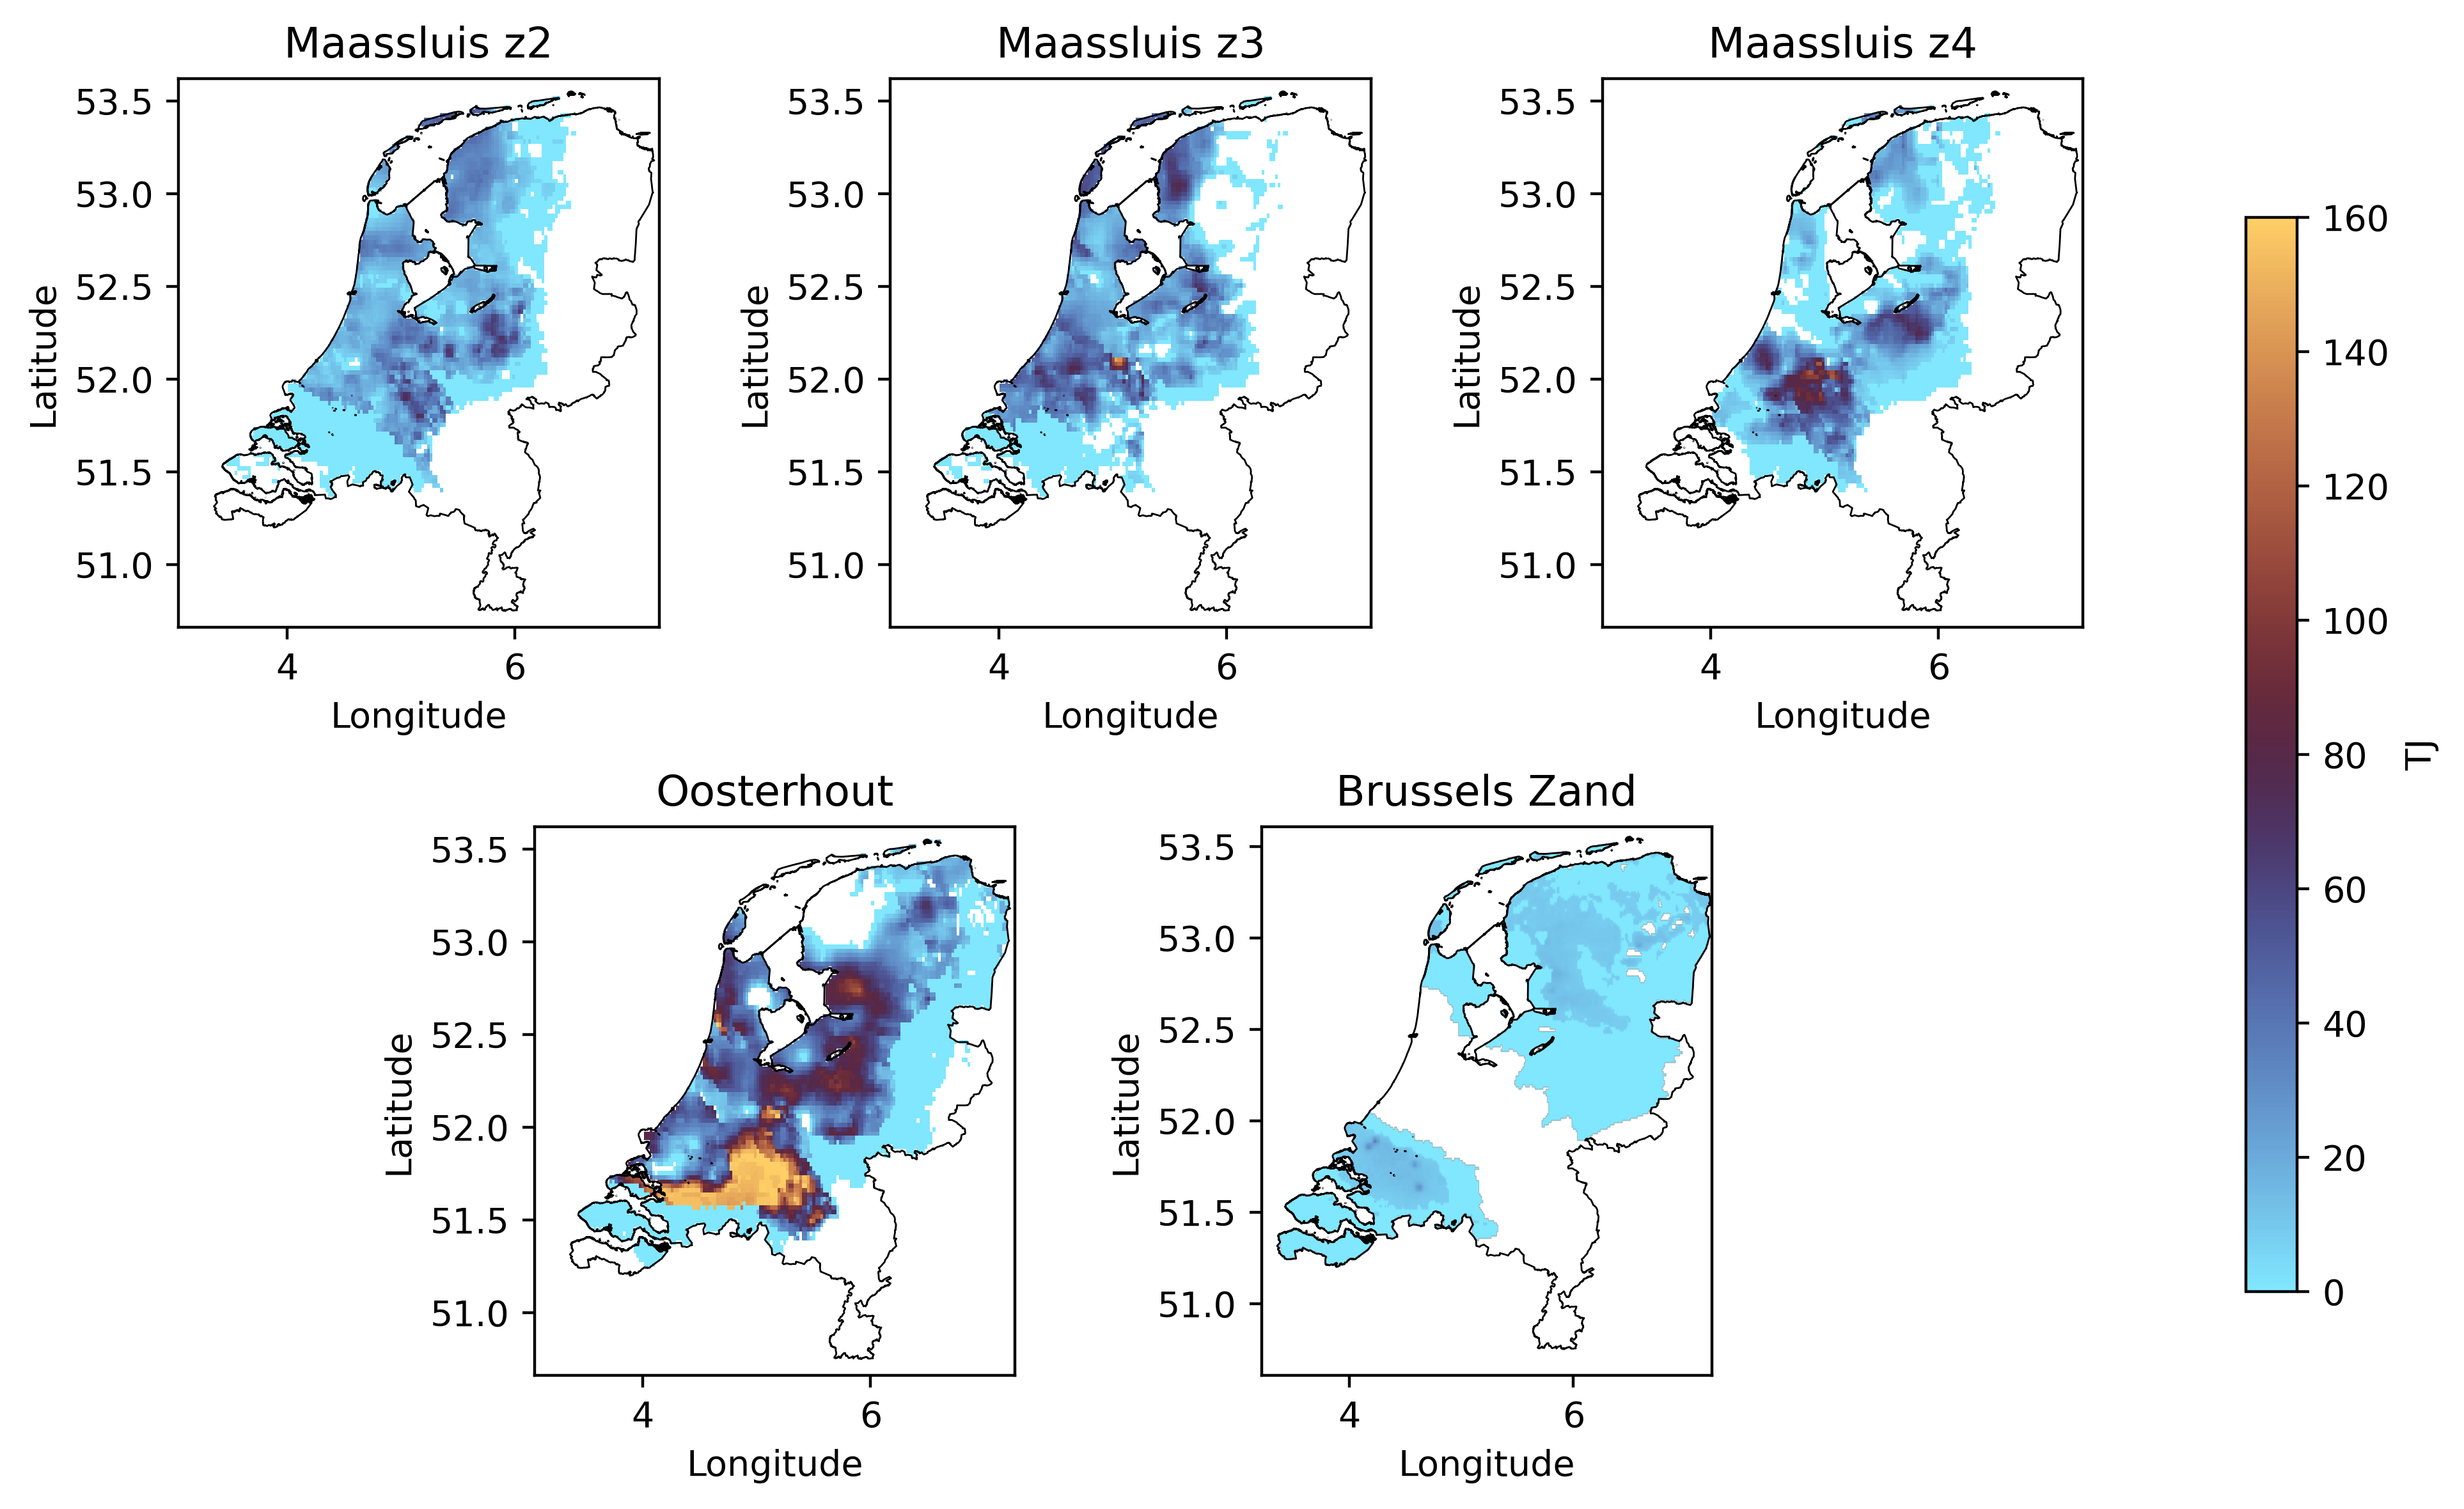

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.crs import CRS
from cmcrameri import cm

netherlands = gpd.read_file("C:/Users/Johannes/PypsaProject/pypsa-eur-htates/Notebooks/NL_borders25.geojson").to_crs(epsg=4326)

layer_names = ['Maassluis z2', 'Maassluis z3', 'Maassluis z4', 'Oosterhout', 'Brussels Zand']
paths = [
    "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz2/msz2__energy_out_P50_basecase_80-45-40.asc",
    "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz3/msz3__energy_out_P50_basecase_80-45-40.asc",
    "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_msz4/msz4__energy_out_P50_basecase_80-45-40.asc",
    "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_ooz2/ooz2__energy_out_P50_basecase_80-45-40.asc",
    "C:/Users/Johannes/PypsaProject/pypsa-eur-htates/data/TNO-HT-ATES/HT-ATES_NLFFS/TG409_NLDOBR__energy_out_P50_ATES.asc"
]

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 6), dpi=400)
gs = GridSpec(2, 6, figure=fig)  # split each row into 6 columns

# Top row: 3 plots, each taking 2 columns
ax1 = fig.add_subplot(gs[0, 0:2])
ax2 = fig.add_subplot(gs[0, 2:4])
ax3 = fig.add_subplot(gs[0, 4:6])

# Bottom row: 2 plots centered — span columns [1:3] and [3:5]
ax4 = fig.add_subplot(gs[1, 1:3])
ax5 = fig.add_subplot(gs[1, 3:5])

axs = [ax1, ax2, ax3, ax4, ax5]


im = None  # placeholder for the image handle

from shapely.geometry import mapping
from rasterio.io import MemoryFile

netherlands_wgs84 = netherlands.to_crs("EPSG:4326")

for ax, path, name in zip(axs, paths, layer_names):
    with rasterio.open(path) as src:
        src_crs = src.crs or CRS.from_epsg(28992)
        dst_crs = CRS.from_epsg(4326)

        data = src.read(1)
        data = np.where(data == src.nodata, np.nan, data)

        # Reproject into a temporary in-memory file
        dst_transform, dst_width, dst_height = calculate_default_transform(
            src_crs, dst_crs, src.width, src.height, *src.bounds
        )

        dst_meta = src.meta.copy()
        dst_meta.update({
            "crs": dst_crs,
            "transform": dst_transform,
            "width": dst_width,
            "height": dst_height
        })

        with MemoryFile() as memfile:
            with memfile.open(**dst_meta) as tmp_dst:
                reproject(
                    source=data,
                    destination=rasterio.band(tmp_dst, 1),
                    src_transform=src.transform,
                    src_crs=src_crs,
                    dst_transform=dst_transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest
                )

                # Now mask using the reprojected Netherlands polygon
                shapes = [mapping(geom) for geom in netherlands_wgs84.geometry]
                masked_data, masked_transform = mask(tmp_dst, shapes, crop=False)
                masked_data = masked_data[0]
                masked_data = np.where(masked_data == tmp_dst.nodata, np.nan, masked_data)

        # Convert from GJ to TJ
        masked_data = masked_data / 1000.0

        # Plot
        extent = [
            masked_transform[2],
            masked_transform[2] + masked_transform[0] * masked_data.shape[1],
            masked_transform[5] + masked_transform[4] * masked_data.shape[0],
            masked_transform[5],
        ]
        im = ax.imshow(
            masked_data,
            extent=extent,
            cmap=cm.managua.reversed(),
            vmin=0,
            vmax=160
        )
        netherlands_wgs84.boundary.plot(ax=ax, color='black', linewidth=0.5)
        ax.set_title(name)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

# Add single shared colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label='TJ')
#fig.suptitle("Energy production in each formation")
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()